In [485]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import seaborn as sb
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import scipy.spatial.distance as ssd
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
!pip install python-louvain
from community import community_louvain

import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import sklearn
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.preprocessing import scale

In [488]:
os.chdir('/Users/gk/Desktop/Northeastern/MSDS/DS5230_Unsupervised_Machine_Learning/Project/Twitter-Network-Analysis/Notebooks/')
nodes = pd.read_csv('/Users/gk/Desktop/Northeastern/MSDS/DS5230_Unsupervised_Machine_Learning/Project/twitter-network-graph/Data/COVID19_NodeList.csv')
edges = pd.read_csv('/Users/gk/Desktop/Northeastern/MSDS/DS5230_Unsupervised_Machine_Learning/Project/Twitter-Network-Analysis/Data/COVID19_EdgeList.csv')

In [490]:
edges.head(3)

,Source,Target,Edge_Freq
0,0,2379,1
1,1,2228,1
2,1,2828,1


In [463]:
nodes.head(2)

,hashtag_name,hashtag_id
0,10000steps,0
1,1000daysartwithnik,1


In [464]:
test = edges['Edge_Freq'][0]
test

1

### Build graph

In [465]:
G = nx.Graph() 

#edge_list = []
for index, edge in edges.iterrows():
    G.add_edge(edge['Source'],edge['Target'],weight=int(edge['Edge_Freq'][...]))
    

#G.add_edges_from(edge_list)

In [467]:
G.get_edge_data(1,2228)

{'weight': 1}

In [468]:
for index, node in nodes.iterrows():
    G.add_node(node['hashtag_id'], hashtag_name=node['hashtag_name'])
g_nodes = G.nodes(data=True)

In [76]:
#test = nx.to_pandas_adjacency(G)
#test.to_csv(r'/Users/gk/Desktop/adjacency_matrix.csv')

### The island in the middle of the network

In [482]:
connected_nodes = sorted(nx.connected_components(G), key = len, reverse=True)[0]
connected_hashtags = nodes[nodes['hashtag_id'].isin(connected_nodes)]
connected_hashtags.to_csv(r'/Users/gk/Desktop/connected_hashtags.csv',index=False)

In [413]:
p = community_louvain.best_partition(G, weight = 'weight', resolution=1.0)

In [414]:
comm_louvain_comparison = pd.DataFrame.from_dict(p.items())
comm_louvain_df = pd.DataFrame(comm_louvain_comparison[1])
comm_louvain_df = comm_louvain_df.rename(columns={1: 'Community'})
df =comm_louvain_df
df.loc[df['Community'].idxmax()]

Community    789
Name: 3509, dtype: int64

In [456]:
cluster_comparison_louvain = nodes.merge(comm_louvain_df, how='outer', left_index=True, right_index=True)
cluster_comparison_louvain[cluster_comparison_louvain['Community']==5]

,hashtag_name,hashtag_id,Community
15,2plan,15,5
16,30DaysOfFree,16,5
17,316Day,17,5
364,CoralSprings,364,5
365,Coranatuerkiye,365,5
366,Cornavirus,366,5
367,CornavirusOutbreak,367,5
368,Cornoavirus,368,5
369,Cornovirus,369,5
370,Coroanvirus,370,5


### greedy_modularity_communities (Clauset-Newman-Moore)

In [447]:
community_list = list(greedy_modularity_communities(G, weight = 'weight'))

nodes[nodes['hashtag_id'].isin(sorted(community_list[11]))]

,hashtag_name,hashtag_id
282,Canadianscientists,282
496,EUROPE,496
550,FactsMatter,550
649,GlobalPandemic,649
818,JVL2,818
1310,RESTAURANTS,1310
1340,ResignNowtrump,1340
1348,Restaurant,1348
1360,Rohingya,1360
1372,SARSCOV2,1372


In [449]:
G.get_edge_data(2604,2607)

### Clustering Coefficients

In [267]:
# Returns the clustering value of each node
clust_coeffs = nx.clustering(G,weight = True)

clust_df = pd.Series(clust_coeffs, name='Cluster Coefficient')

clust_df.index.name = 'Node'

clust_df = clust_df.reset_index()

clust_df = pd.merge(clust_df, nodes, how='left', left_on=['Node'], right_on=['hashtag_id'])

clust_df = clust_df[['hashtag_name','Cluster Coefficient']]
clust_df

,hashtag_name,Cluster Coefficient
0,10000steps,0.000000
1,firstresponders,0.000000
2,1000daysartwithnik,1.000000
3,day1,1.000000
4,nhpolitics,1.000000
...,...,...
3232,โควิด,0.400000
3233,โควิด19,0.666667
3234,ポケ森写真部,1.000000
3235,モンストフェアリーテイル,1.000000


### Distances metric

In [9]:
distances = dict(nx.all_pairs_shortest_path_length(G))

In [10]:
node_distances = []
for node1 in distances:
    for node2 in distances[node1]:
        node_distances.append([node1, node2, distances[node1][node2]])

#dataMatrix = np.array([distances[i] for i in range(len(distances))])

#dataMatrix[10]
#distances_matrix = np.reshape(distances, (len(distances),len(distances)))

# convert the redundant n*n square matrix form into a condensed nC2 array
#distArray = ssd.squareform(dataMatrix) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j

In [11]:
distance_df = pd.DataFrame(node_distances, columns = ['Source','Target','Distance'])

In [269]:
distance_df = distance_df.sample(n=30000)

### Dendrogram

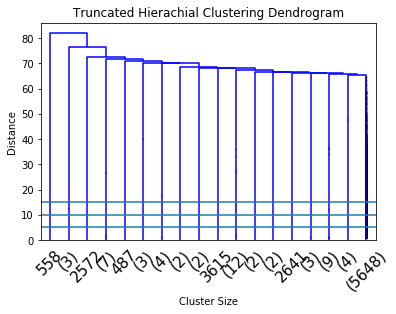

In [283]:
# Pretty this up

data = linkage(edges,'single')
dendrogram(data, truncate_mode= "lastp", p =18, leaf_rotation=45,leaf_font_size=15, show_contracted=True)
plt.title("Truncated Hierachial Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
#divide the cluster
plt.axhline(y=15)
plt.axhline(5)
plt.axhline(10)
plt.show()

### Plot clusters

In [312]:
#select c based on the dendrogram
c=18
#build the model
HClustering = AgglomerativeClustering(n_clusters=c , affinity="euclidean",linkage="ward")
#fit the model on the dataset
HClustering.fit(edges)
labels = HClustering.labels_

h_clustering_silhouette = silhouette_score(edges, labels, metric='euclidean')
h_clustering_CH = calinski_harabasz_score(edges, labels)

In [313]:
h_clustering_silhouette

0.3082014352553451

In [314]:
h_clustering_CH

7777.407737301696

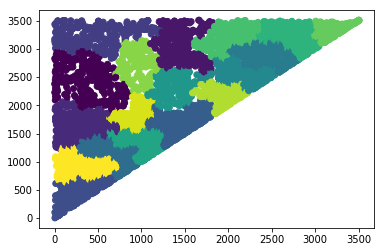

In [315]:
plt.scatter(edges.iloc[:,0], edges.iloc[:,1],c=labels, cmap='viridis')
plt.show()

In [451]:
labels_df = pd.DataFrame(labels)
edges['label'] = labels_df

In [455]:
edges_comparision = pd.merge(edges,nodes, how='left', left_on=['Source'], right_on=['hashtag_id'])
edges_comparision[edges_comparision['label']==16].head(30)

,Source,Target,Edge_Freq,label,hashtag_name,hashtag_id
1626,633,1774,1,16,Gaslighting,633
1639,639,1785,1,16,Germany,639
1662,651,1758,1,16,GlobalWarming,651
1695,674,1726,1,16,HHS,674
1704,680,1815,1,16,HRes897,680
1718,688,1768,1,16,Handsanitize,688
1719,689,1768,1,16,Handwash,689
1720,691,1810,1,16,HappeningNow,691
1723,693,1783,2,16,HappyHour,693
1726,696,1726,1,16,Hawaii,696


# Spot Check, Do the clusters make sense? NO
# Histogram hashtags, histogram paired hashtags

# Use Edit Distance: insert, delete, substitution